In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from librosa import core, onset, feature, display
import soundfile as sf
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv("data/birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [3]:
def load_audio(file_id):
    data, samplerate = sf.read("data/songs/xc"+str(file_id)+".flac")
    # data, samplerate = sf.read("data/songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(y = data, sr=samplerate, hop_length=512)

    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()

    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

df['length'] = np.zeros(len(df))

waves = {}

for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    # print(len(data[audio_mask])/sample_rate)

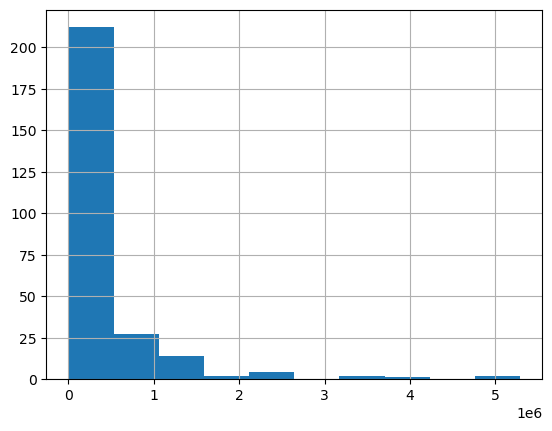

count    2.640000e+02
mean     4.307546e+05
std      6.611052e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [4]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df['length'].hist()
plt.show()
df['length'].describe()

<BarContainer object of 66 artists>

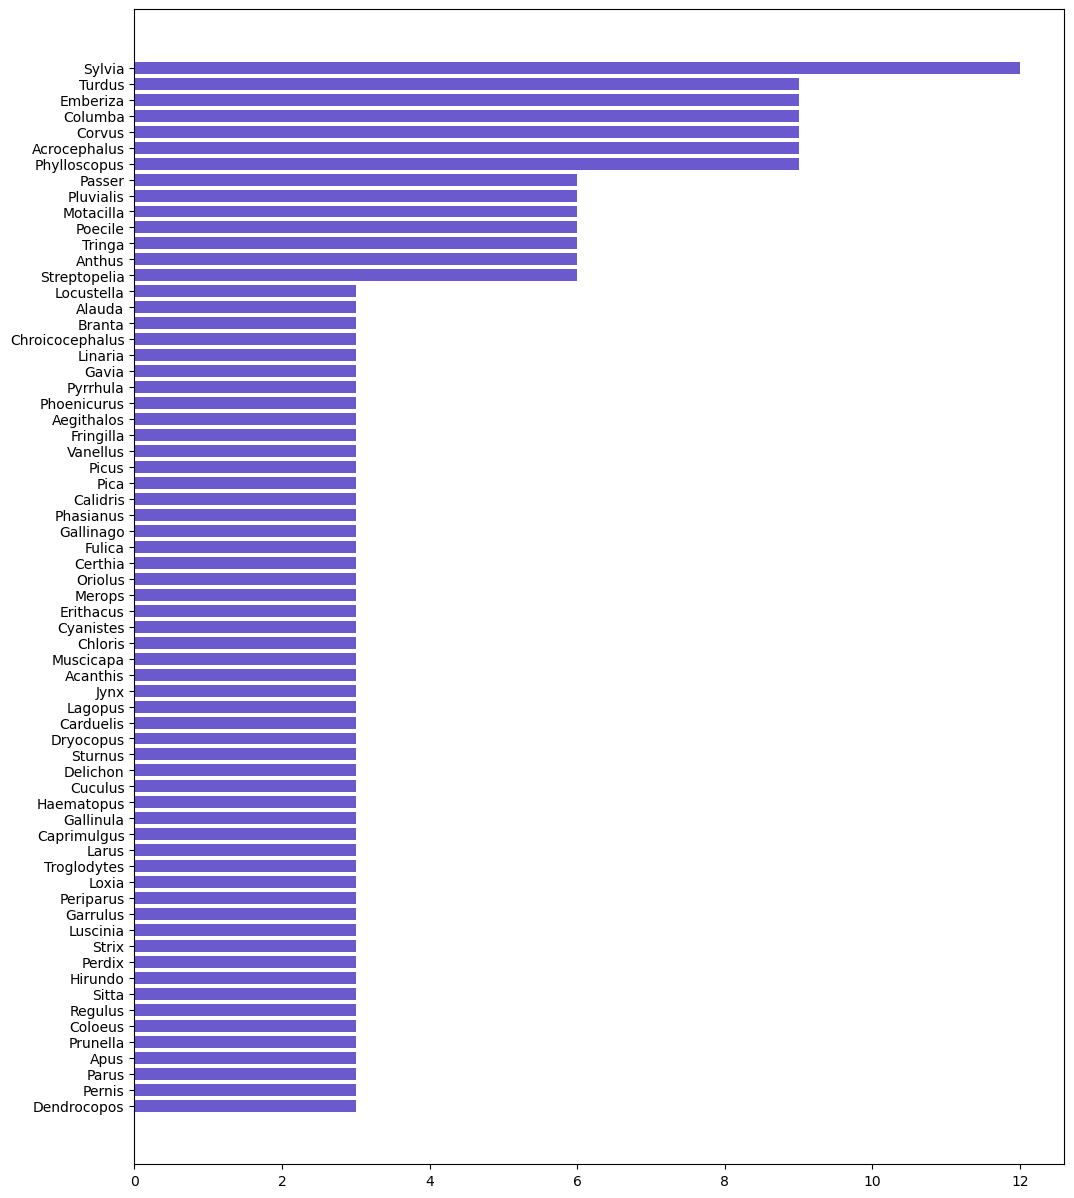

In [5]:
counts = [list(df.genus).count(code) for code in set(df.genus)]
idx = np.argsort(counts)
y = np.array(counts)[idx]
code_dict = np.array(list(set(df.genus)))[idx]
fig, ax = plt.subplots(figsize=(12,15))
ax.barh(code_dict, y, height=0.75, color="slateblue")

# val.plot(kind="bar")


## Understanding melspectrogram

To understand the melspectrogram, one needs to first understand the fourier transform. In simple terms, it is a transformation that allows us to analyze the frequency content of a signal effectively. But unfortunately, the fourier transform requires the signal to be periodic to get optimal results.

This problem can be solved by applying the fourier transform on multiple windowed segments of the signals to capture the frequency content as it changes over time. This is called the short-time fourier transform or STFT for short. When the fourier transform is applied on overlapping windowed segments of the signal, what we get what is called a spectrogram.

A spectrogram can be thought of as several fourier transforms stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. The y-axis is converted to a log scale, and the color dimension is converted to decibels. This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.

Moreover, studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same. In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.

A spectrogram converted to the mel scale is called a melspectrogram and is a great way to convert audio signal data to a visual feature map to train an image model (like ResNet-34) on. Refer to this article for an excellent explanation of melspectrogram. Now, since we understand how the melspectrogram works, let us move on to the modelling part

## Visualize melspectrogram

Next we visualize the melspectrogram feature maps for sample signals to get an better understanding. We can see that the melspectrogram contains visual information about the trends (frequency and amplitude) in the audio signal over time.


In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have some audio data in 'y' and 'sr' (sampling rate)
y, sr = librosa.load("data/songs/xc"+str(file_id)+".flac")
# y, sr = librosa.load("data/songs/songs/xc"+str(file_id)+".flac")


def show_melspectrogram(data, samplerate):
    # Compute the Mel spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=data, sr=samplerate)

    # Convert power spectrogram to dB
    melspectrogram_db = librosa.power_to_db(melspectrogram)

    # Normalize the Mel spectrogram to [0, 255]
    normalized_melspectrogram = librosa.util.normalize(melspectrogram_db)

    # Convert to image representation
    image = librosa.display.specshow(normalized_melspectrogram, cmap='viridis')

    # Plot or use the image for further processing
    plt.show()



def get_melspectrogram(data, samplerate):
    # Compute the Mel spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=data, sr=samplerate)

    # Convert power spectrogram to dB
    melspectrogram_db = librosa.power_to_db(melspectrogram)

    # Normalize the Mel spectrogram to [0, 255]
    normalized_melspectrogram = librosa.util.normalize(melspectrogram_db)

    return normalized_melspectrogram

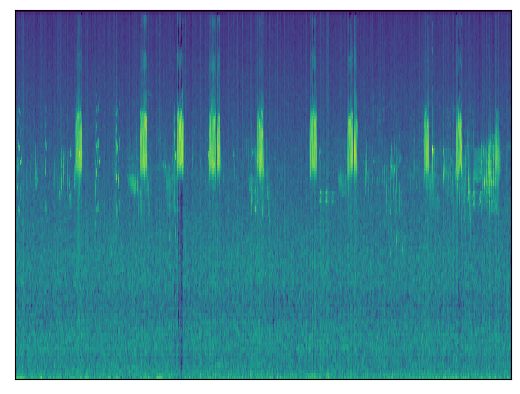

array([[-1.        , -0.80360382, -0.48436433, ..., -0.43367143,
        -0.71075901, -1.        ],
       [-1.        , -0.77955224, -0.56834785, ..., -0.40401866,
        -0.69857656, -1.        ],
       [-1.        , -0.77090434, -0.49139097, ..., -0.48146676,
        -0.7131691 , -1.        ],
       ...,
       [-1.        , -1.        , -0.75317733, ..., -0.76814536,
        -0.98518748, -1.        ],
       [-1.        , -1.        , -0.871422  , ..., -0.81166968,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [7]:
# visualize one example of spectrogram
file_id = 132608
data, samplerate = sf.read("data/songs/xc"+str(file_id)+".flac")
# data, samplerate = sf.read("data/songs/songs/xc"+str(file_id)+".flac")
show_melspectrogram(data, samplerate)
get_melspectrogram(data, samplerate)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import librosa
import librosa.display
from librosa import core, onset, feature, display
import soundfile as sf
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader

# Load and preprocess data
df = pd.read_csv("data/birdsong_metadata.csv")

# Split data into training and the rest
train_data, rest_data = train_test_split(df, test_size=0.3, random_state=42)

# Split the rest into validation and testing
validation_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=42)

def get_melspectrogram(data, samplerate):
    # Compute the Mel spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=data, sr=samplerate)

    # Convert power spectrogram to dB
    melspectrogram_db = librosa.power_to_db(melspectrogram)

    # Normalize the Mel spectrogram to [0, 255]
    normalized_melspectrogram = librosa.util.normalize(melspectrogram_db)

    return normalized_melspectrogram

# Feature extraction
def extract_features(data, max_length):
    features = []
    labels = []
    for idx, row in data.iterrows():
        file_id = row['file_id']
        genus_label = row['genus']  # Assuming 'genus' is the column containing labels
        # Load audio file
        file_path = "data/songs/xc{}.flac".format(file_id)
        data, samplerate = librosa.load(file_path)
        
        # Extract Mel spectrogram features
        melspectrogram = get_melspectrogram(data, samplerate)
        
        # Pad or truncate the features to a fixed length
        padded_melspectrogram = np.pad(melspectrogram, ((0, 0), (0, max_length - melspectrogram.shape[1])), mode='constant')
        
        # Flatten the spectrogram
        flattened_melspectrogram = padded_melspectrogram.reshape(-1)
        
        # Append features and labels
        features.append(flattened_melspectrogram)
        labels.append(genus_label)
    
    return np.array(features), np.array(labels)

# Find the maximum length of Mel spectrogram features
max_length = max(len(get_melspectrogram(librosa.load("data/songs/xc{}.flac".format(file_id))[0], librosa.load("data/songs/xc{}.flac".format(file_id))[1])[1]) for file_id in df['file_id'])

# Extract features with padding
train_features, train_labels = extract_features(train_data, max_length)
validation_features, validation_labels = extract_features(validation_data, max_length)
test_features, test_labels = extract_features(test_data, max_length)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [13]:
# Train Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(train_features)

# Compute nearest neighbors for validation and testing data
validation_distances, validation_indices = nn_model.kneighbors(validation_features)
test_distances, test_indices = nn_model.kneighbors(test_features)

print("Shape of train_features:", train_features.shape)
print("Shape of validation_features:", validation_features.shape)
print("Shape of test_features:", test_features.shape)

Shape of train_features: (184, 1390208)
Shape of validation_features: (40, 1390208)
Shape of test_features: (40, 1390208)


In [14]:
# Apply Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(train_features, train_labels_encoded)

print("Shape of validation_indices:", validation_indices.shape)
print("Shape of test_indices:", test_indices.shape)

# Predict labels for validation and testing data
validation_predictions_encoded = nb_model.predict(validation_features)
test_predictions_encoded = nb_model.predict(test_features)
# validation_predictions_encoded = nb_model.predict(train_labels_encoded[validation_indices])
# test_predictions_encoded = nb_model.predict(train_labels_encoded[test_indices])

Shape of validation_indices: (40, 5)
Shape of test_indices: (40, 5)


In [15]:
# Decode predicted labels (if needed)
validation_predictions = label_encoder.inverse_transform(validation_predictions_encoded)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Evaluate model
validation_accuracy = accuracy_score(validation_labels_encoded, validation_predictions_encoded)
test_accuracy = accuracy_score(test_labels_encoded, test_predictions_encoded)

print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.0
Test Accuracy: 0.025


In [17]:
# Evaluate model
validation_accuracy = accuracy_score(validation_labels, validation_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.0
Test Accuracy: 0.025


In [14]:
validation_indices.shape, train_features.shape, train_labels.shape

((40, 5), (184, 1390208), (184,))

In [11]:
for i in validation_indices:
    print(train_labels_encoded[i])

[14 53 39 64  0]
[ 1 16 10 54 14]
[17 61 11 56 57]
[ 6  7 64 48 62]
[55 27 14 59 23]
[34 47 64 21 64]
[32 31 60 26 34]
[56 64 36  4 21]
[46 62 36 60 25]
[18  8 27 13 44]
[58 58 62 21 15]
[15 58 36 13 18]
[58 12 13 33 62]
[34 37  1 21 47]
[61 49  1 52 42]
[10 14 34 49 15]
[44 53 65 27 18]
[ 1 42 43 33 17]
[14 59 55 14 13]
[18  8 13 65 44]
[64 49 58 54 35]
[58 60 61 25 36]
[64 36 58 56 21]
[55 34 59 15 27]
[21 62 58  2 25]
[34 49  1 21 37]
[50 43 54 20 33]
[ 9 50 26  6 14]
[ 0 42 58 11 65]
[ 5 64 25 39 61]
[60  2 36 46 40]
[14 14  0 26 13]
[53 44  9  0  1]
[50  9 11 25  6]
[15 52 59 43 49]
[ 1 21 34 47 37]
[ 8 50 64  0 11]
[40 64 53 64  7]
[29 49 50 54 35]
[ 4  2 11 25 11]


In [18]:
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from librosa import feature
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load and preprocess data
df = pd.read_csv("data/birdsong_metadata.csv")

# Split data into training and the rest
train_data, rest_data = train_test_split(df, test_size=0.3, random_state=42)

# Split the rest into validation and testing
validation_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=42)

# Preprocessing and feature extraction functions
def load_and_preprocess_audio(file_id, max_length):
    data, samplerate = sf.read("data/songs/xc" + str(file_id) + ".flac")
    s = len(data) / samplerate
    sg = feature.melspectrogram(y=data, sr=samplerate, hop_length=512)

    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:, centerpoint].mean()

    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0) >= M / 20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0, len(mask)):
        audio_mask[i * 512:] = mask[i]

    # Apply the audio mask to retain only high-energy frames
    filtered_data = data[audio_mask]

    # Pad or truncate the spectrogram to a fixed length
    padded_sg = np.pad(sg, ((0, 0), (0, max_length - sg.shape[1])), mode='constant')

    return padded_sg, filtered_data, samplerate

def extract_features(data, max_length):
    features = []
    labels = []
    for idx, row in data.iterrows():
        file_id = row['file_id']
        genus_label = row['genus']  # Assuming 'genus' is the column containing labels
        # Load and preprocess audio
        sg, filtered_data, samplerate = load_and_preprocess_audio(file_id, max_length)
        
        # Flatten the spectrogram
        flattened_sg = sg.reshape(-1)
        
        # Append features and labels
        features.append(flattened_sg)
        labels.append(genus_label)
    
    return np.array(features), np.array(labels)

# Find the maximum length of Mel spectrogram features
max_length = max(len(load_and_preprocess_audio(file_id, 0)[0][1]) for file_id in df['file_id'])

# Extract features with padding
train_features, train_labels = extract_features(train_data, max_length)
validation_features, validation_labels = extract_features(validation_data, max_length)
test_features, test_labels = extract_features(test_data, max_length)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Train Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(train_features)

# Compute nearest neighbors for validation and testing data
validation_distances, validation_indices = nn_model.kneighbors(validation_features)
test_distances, test_indices = nn_model.kneighbors(test_features)

# Apply Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(train_features, train_labels_encoded)

# Predict labels for validation and testing data
validation_predictions_encoded = nb_model.predict(validation_features)
test_predictions_encoded = nb_model.predict(test_features)

# Decode predicted labels (if needed)
validation_predictions = label_encoder.inverse_transform(validation_predictions_encoded)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Evaluate model
validation_accuracy = accuracy_score(validation_labels_encoded, validation_predictions_encoded)
test_accuracy = accuracy_score(test_labels_encoded, test_predictions_encoded)

print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)


ValueError: index can't contain negative values

In [19]:
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from librosa import feature
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load and preprocess data
df = pd.read_csv("data/birdsong_metadata.csv")

# Split data into training and the rest
train_data, rest_data = train_test_split(df, test_size=0.3, random_state=42)

# Split the rest into validation and testing
validation_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=42)

# Preprocessing and feature extraction functions
def load_and_preprocess_audio(file_id):
    data, samplerate = sf.read("data/songs/xc" + str(file_id) + ".flac")
    s = len(data) / samplerate
    sg = feature.melspectrogram(y=data, sr=samplerate, hop_length=512)

    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:, centerpoint].mean()

    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0) >= M / 20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0, len(mask)):
        audio_mask[i * 512:] = mask[i]

    # Apply the audio mask to retain only high-energy frames
    filtered_data = data[audio_mask]

    return sg, filtered_data, samplerate

def extract_features(data, max_length):
    features = []
    labels = []
    for idx, row in data.iterrows():
        file_id = row['file_id']
        genus_label = row['genus']  # Assuming 'genus' is the column containing labels
        # Load and preprocess audio
        sg, filtered_data, samplerate = load_and_preprocess_audio(file_id)
        
        # Pad or truncate the spectrogram to a fixed length
        padded_sg = np.pad(sg, ((0, 0), (0, max_length - sg.shape[1])), mode='constant')[:,:max_length]
        
        # Flatten the spectrogram
        flattened_sg = padded_sg.reshape(-1)
        
        # Append features and labels
        features.append(flattened_sg)
        labels.append(genus_label)
    
    return np.array(features), np.array(labels)

# Find the maximum length of Mel spectrogram features
max_length = max(len(load_and_preprocess_audio(file_id)[0][1]) for file_id in df['file_id'])

# Extract features with padding
train_features, train_labels = extract_features(train_data, max_length)
validation_features, validation_labels = extract_features(validation_data, max_length)
test_features, test_labels = extract_features(test_data, max_length)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Train Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(train_features)

# Compute nearest neighbors for validation and testing data
validation_distances, validation_indices = nn_model.kneighbors(validation_features)
test_distances, test_indices = nn_model.kneighbors(test_features)

# Apply Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(train_features, train_labels_encoded)

# Predict labels for validation and testing data
validation_predictions_encoded = nb_model.predict(validation_features)
test_predictions_encoded = nb_model.predict(test_features)

# Decode predicted labels (if needed)
validation_predictions = label_encoder.inverse_transform(validation_predictions_encoded)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Evaluate model
validation_accuracy = accuracy_score(validation_labels_encoded, validation_predictions_encoded)
test_accuracy = accuracy_score(test_labels_encoded, test_predictions_encoded)

print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)


Validation Accuracy: 0.075
Test Accuracy: 0.05


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from librosa import feature

# Load metadata
df = pd.read_csv("data/birdsong_metadata.csv")

# Define a function to extract features from audio data
def extract_features(file_id):
    data, samplerate = sf.read("data/songs/xc" + str(file_id) + ".flac")
    mel_spectrogram = feature.melspectrogram(y=data, sr=samplerate)
    return mel_spectrogram.flatten()  # Flatten the spectrogram

# Prepare features and labels
X = []  # Features (Mel spectrograms)
y = []  # Labels

# Label encoding
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['genus'])  # Assuming 'genus' contains the class labels

for file_id, row in df.iterrows():
    label = row['encoded_label']
    features = extract_features(row['file_id'])
    X.append(features)
    y.append(label)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the NBNN classifier
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5), GaussianNB())
clf.fit(X_train, y_train)

# Evaluate the classifier
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'KNeighborsClassifier()' (type <class 'sklearn.neighbors._classification.KNeighborsClassifier'>) doesn't

In [22]:
df

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from librosa import feature

df = pd.read_csv("data/birdsong_metadata.csv")

# Extract features from audio data with fixed length
def extract_features(file_id, max_length):
    data, samplerate = sf.read("data/songs/xc" + str(file_id) + ".flac")
    mel_spectrogram = feature.melspectrogram(y=data, sr=samplerate)
    padded_spectrogram = np.zeros((mel_spectrogram.shape[0], max_length))
    padded_spectrogram[:, :mel_spectrogram.shape[1]] = mel_spectrogram[:, :max_length]
    return padded_spectrogram.flatten()  # Flatten the padded spectrogram

# Calculate the maximum length of spectrograms
max_length = 0
for file_id in df['file_id']:
    data, samplerate = sf.read("data/songs/xc" + str(file_id) + ".flac")
    mel_spectrogram = feature.melspectrogram(y=data, sr=samplerate)
    max_length = max(max_length, mel_spectrogram.shape[1])


# Prepare features and labels
X = []  # Features (Mel spectrograms)
y = []  # Labels

# Label encoding
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['genus'])

for file_id, row in df.iterrows():
    label = row['encoded_label']
    features = extract_features(row['file_id'], max_length)
    X.append(features)
    y.append(label)

# Convert X to 2D array
X = np.array(X)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

Accuracy: 0.1125
F1-score: 0.08849206349206348


In [6]:
y_pred

array([ 8,  8, 38, 38,  8, 43,  8, 11, 43, 35, 61, 35, 35, 35, 29,  8, 13,
       29, 15, 11,  1, 53, 35,  8, 43, 32, 35, 37,  8, 29, 29, 24,  8, 60,
        1, 38, 43,  8,  8, 35, 35,  3, 43,  3,  3,  8, 32, 53, 35, 35, 35,
       35, 35, 61, 35, 15, 29, 43, 43, 15,  8, 31, 61,  1, 14,  1,  8, 35,
       35,  8, 43, 15,  8, 29,  8, 35, 43, 15,  8, 35])

In [7]:
X.shape

(264, 2780288)